<a href="https://www.kaggle.com/code/kapturovalexander/reg-ps-s5-e5-predict-calorie-expenditure?scriptVersionId=237167985" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![competition image](https://www.kaggle.com/competitions/91716/images/header)

## **Your Goal**: Your goal is to predict how many calories were burned during a workout.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/calories-burnt-prediction/calories.csv
/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


#### **Version 1** Baseline withous original data, Optuna and EDA. Just 100 iteration on CatBoost
#### **Version 2** (PS -> 0.07526) Just fixed error <span style="color: red">Mean Squared Logarithmic Error cannot be used when targets contain negative values.</span> using test_shift ```test_shift = y_pred_test.min()```
#### **Version 3** Just added ```test_shift = y_pred_test.min()``` only to negative **Calories** values
#### **Version 4** Fixed new error using ```np.where()```

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import optuna
# from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import StackingRegressor
# from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

In [3]:
original_train = pd.read_csv('/kaggle/input/calories-burnt-prediction/calories.csv')

train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')
print('OK')

OK


In [4]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [5]:
print(original_train.shape)
original_train.columns.tolist()

(15000, 9)


['User_ID',
 'Gender',
 'Age',
 'Height',
 'Weight',
 'Duration',
 'Heart_Rate',
 'Body_Temp',
 'Calories']

#### We should remove ID columns and rename 'Gender' to 'Sex' like in train/test

In [6]:
submission_id = test.id

train.drop(columns='id', axis=1, inplace=True)
test.drop(columns='id', axis=1, inplace=True)

In [7]:
original_train.drop(columns='User_ID', axis=1, inplace=True)
original_train.rename(columns={'Gender': 'Sex'}, inplace=True)

In [8]:
print(train.columns)
print(original_train.columns)

Index(['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories'],
      dtype='object')
Index(['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories'],
      dtype='object')


In [9]:
test.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,male,45,177.0,81.0,7.0,87.0,39.8
1,male,26,200.0,97.0,20.0,101.0,40.5
2,female,29,188.0,85.0,16.0,102.0,40.4
3,female,39,172.0,73.0,20.0,107.0,40.6
4,female,30,173.0,67.0,16.0,94.0,40.5


#### Obviously that **Calories** is our target

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,750000.0,41.420404,15.175049,20.0,28.0,40.0,52.0,79.0
Height,750000.0,174.697685,12.824496,126.0,164.0,174.0,185.0,222.0
Weight,750000.0,75.145668,13.982704,36.0,63.0,74.0,87.0,132.0
Duration,750000.0,15.421015,8.354095,1.0,8.0,15.0,23.0,30.0
Heart_Rate,750000.0,95.483995,9.449845,67.0,88.0,95.0,103.0,128.0
Body_Temp,750000.0,40.036253,0.779875,37.1,39.6,40.3,40.7,41.5
Calories,750000.0,88.282781,62.395349,1.0,34.0,77.0,136.0,314.0


#### The statistics look clean, with no obvious outliers at first glance and fairly stable.

In [11]:
print('TRAIN data\n')
print(f'{train.isna().sum()}\n\n\n')

print('TEST data\n')
print(f'{test.isna().sum()}\n\n\n')

print('ORIGINAL data\n')
print(original_train.isna().sum())

TRAIN data

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64



TEST data

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64



ORIGINAL data

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64


#### There are no gaps in the data.

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         750000 non-null  object 
 1   Age         750000 non-null  int64  
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 45.8+ MB


In [13]:
print('TRAIN data shape\n')
print(f'{train.shape}\n\n')

print('TEST data shape\n')
print(f'{test.shape}\n\n')

print('ORIGINAL data shape\n')
print(original_train.shape)

TRAIN data shape

(750000, 8)


TEST data shape

(250000, 7)


ORIGINAL data shape

(15000, 8)


#### There are 1 million observations in the competition data and 15.000 in the original dataset

In [14]:
train['Sex'].value_counts()

Sex
female    375721
male      374279
Name: count, dtype: int64

In [15]:
train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [16]:
# Split the train data into X and y
X = train.drop(['Calories'], axis=1)
y = train['Calories']

CPU times: user 2min 59s, sys: 4.93 s, total: 3min 4s
Wall time: 48.9 s


<Axes: >

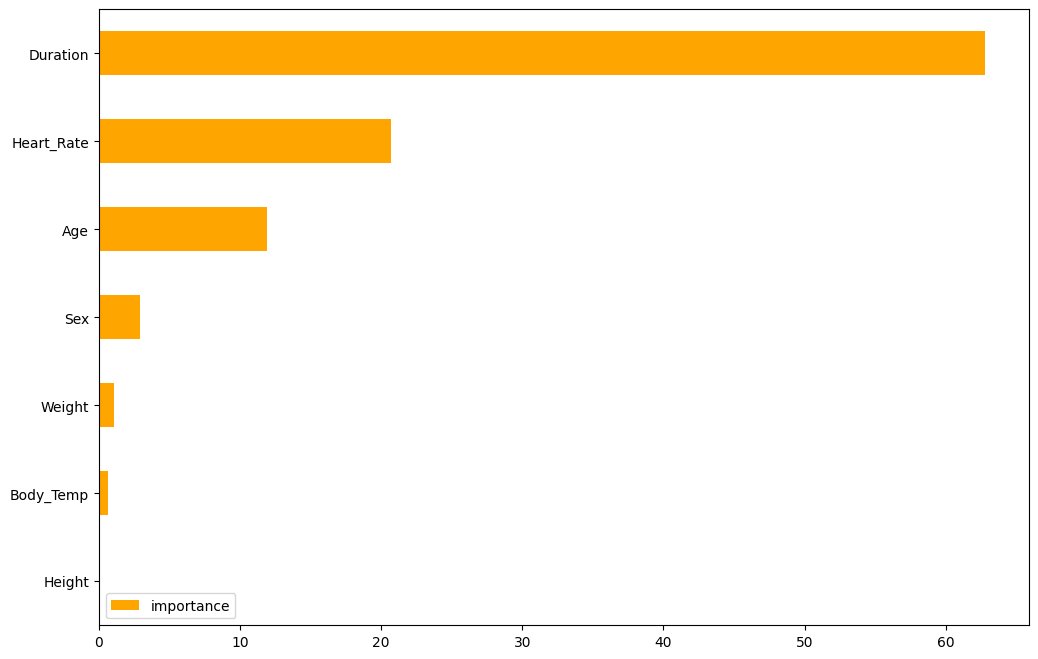

In [17]:
%%time
best_cat = CatBoostRegressor(
    cat_features=['Sex'],  # Fixed typo: 'сat_features' → 'cat_features'
    verbose=False,
    random_seed=28,  # Note: 'random_seed' is fine, but 'random_state' is also commonly used
)

best_cat.fit(X, y)

importance = best_cat.feature_importances_
feature_importance = pd.DataFrame(
    data=importance,
    index=X.columns,
    columns=['importance']
).sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(12, 8), color='orange')

#### **Duration** is the most important feature in the X sub-data

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=28)

In [19]:
%%time
model = CatBoostRegressor(
    iterations=100, 
    cat_features=['Sex'],
    random_seed=28,
    verbose=False
)

model.fit(X, y)

CPU times: user 19.2 s, sys: 570 ms, total: 19.8 s
Wall time: 5.35 s


In [20]:
y_pred_val = model.predict(X_val)

print("Negative values in y_pred_val:", (y_pred_val < 0).any(), "Count:", (y_pred_val < 0).sum())
print("Min value in y_pred_val:", y_pred_val.min())

Negative values in y_pred_val: True Count: 10
Min value in y_pred_val: -0.7558220047329343


In [21]:
min_val = min(y_val.min(), y_pred_val.min())
shift = abs(min_val) + 1 if min_val < 0 else 0
shift

1.7558220047329343

In [22]:
y_val_shifted = y_val + shift
y_pred_val_shifted = y_pred_val + shift

rmsle_val = np.sqrt(mean_squared_log_error(y_val_shifted, y_pred_val_shifted))
print(f"Validation RMSLE with shifted values: {rmsle_val:.8f}")

Validation RMSLE with shifted values: 0.05986424


In [23]:
# y_pred_val = model.predict(X_val)

# rmsle_val = np.sqrt(mean_squared_log_error(y_val, y_pred_val))
# print(f"Validation Root mean squared logarithmic error regression loss: {rmsle_val:.8f}")

In [24]:
y_pred_test = model.predict(test)
y_pred_test[:10]

array([ 27.22140015, 107.49337286,  89.65330009, 125.49849914,
        76.57350975,  22.28339184,  47.61375687,   7.17234462,
        10.63049754, 202.37883247])

In [25]:
test_shift = y_pred_test.min()
test_shift

-0.7462856609233626

In [26]:
shift = abs(test_shift) + 1e-8 if test_shift < 0 else 1e-8
y_pred_test_shifted = np.where(y_pred_test < 0, y_pred_test + shift, y_pred_test)

submission = pd.DataFrame({
    'id': sample_submission['id'],
    'Calories': y_pred_test_shifted
})

submission.to_csv('Kapturov_S5E5_submission_3.csv', index=False)
submission.head(10)

,id,Calories
0,750000,27.221400
1,750001,107.493373
2,750002,89.653300
3,750003,125.498499
4,750004,76.573510
5,750005,22.283392
6,750006,47.613757
7,750007,7.172345
8,750008,10.630498
9,750009,202.378832
